# Fichier lancement des expériences Azure Machine learning pour la détermination du meilleur modèle à déployer sous forme d'API

In [1]:
#### Importer le dataset et datastore
from azureml.core import Dataset, Datastore

##### Création d'un environnement organisé
from azureml.core import Workspace, Environment

from azureml.core.compute import ComputeTarget, AmlCompute

from azureml.core.environment import CondaDependencies
from azureml.core.runconfig import DockerConfiguration


Afin d'aboutir à des résultas rapidement, un GPU est utilisé pour la réalisation des expériences.

In [2]:
#___________________Création de l'environnement et chargement des dépendances_____________

ws = Workspace.from_config(path='./', _file_name='config.json')
env_list = Environment.list(workspace=ws) 
env_selected = env_list['AzureML-TensorFlow-2.3-GPU'].clone('TensorFlow-2.3-GPU')

env_selected.docker.enabled = True
#docker_config = DockerConfiguration(use_docker=True)


conda_dep = env_selected.python.conda_dependencies

conda_dep.add_conda_package('pip')
conda_dep.add_conda_package('pandas')
conda_dep.add_conda_package('numpy')
conda_dep.add_conda_package('scikit-learn')
conda_dep.add_conda_package('matplotlib')
conda_dep.remove_pip_package('horovod')
conda_dep.remove_pip_package('cmake')
conda_dep.add_conda_package('tensorflow')
conda_dep.add_conda_package('keras')
conda_dep.add_conda_package('IPython')
conda_dep.add_conda_package('nltk')
conda_dep.add_pip_package("albumentations")
#conda_dep.add_pip_package("cityscapesscripts")
conda_dep.add_pip_package("segmentation-models")
#conda_dep.add_pip_package("opencv-python")
conda_dep.add_pip_package('opencv-python-headless')#('cv2')
conda_dep.add_pip_package("pillow==5.4.1")

env_selected.python
env_selected.python.conda_dependencies = conda_dep
#env_selected

'enabled' is deprecated. Please use the azureml.core.runconfig.DockerConfiguration object with the 'use_docker' param instead.


In [3]:
###### Créer une expérience
from azureml.core import Experiment

# Ci-après une liste de noms d'expériences, elles sont appelées l'une à suite de l'autre

#experiment_name = 'test_unet_sans_augmentation'
#experiment_name = 'test_unet_augmentation'
experiment_name ='backbone_augmentation'


experiment = Experiment(workspace=ws, name=experiment_name)

#from azureml.core.compute import ComputeTarget, AmlCompute

In [4]:
# Créer une instance de calcul
compute_name = "p8-compute"
compute_target = AmlCompute(workspace=ws, name=compute_name)

In [5]:
compute_targets = ws.compute_targets
for name, ct in compute_targets.items():
    print(name, '-', ct.type, ct.provisioning_state )

p8-compute - AmlCompute Succeeded


In [6]:
# Get the datastore to upload prepared data
datastore = ws.get_default_datastore()
# Upload de l'arborescence for the first execution
# upload the local directory from src_dir to the target_path in datastore
#datastore.upload(src_dir='preprocessed',
#                 target_path='preprocessed',
#                 overwrite=True,
#                 show_progress=False)

In [7]:
print(datastore.name, datastore.datastore_type, datastore.account_name, datastore.container_name)


workspaceblobstore AzureBlob mlprojet89754875384 azureml-blobstore-2513d516-b919-4e4b-b6ba-29d02404c27f


In [8]:
# Exécution du script- Récupération de l'emplacement
script_folder = './scripts/'
args = ['--data-folder',datastore.as_mount()]

In [9]:
# Upload des fichiers dans le dataset
ds_paths = [(datastore, 'preprocessed/')]
dataset = Dataset.File.from_files(path = ds_paths)

In [ ]:
dataset.to_path()

In [11]:
script_arguments = ['--data-folder', dataset.as_named_input('preprocessed').as_mount()]

In [31]:
# Créer la configuration d’exécution du script
from azureml.core import ScriptRunConfig

# Ci-après une configuration appelée par tour de role suivant le script 
#du programme utilislé


config = ScriptRunConfig(source_directory = script_folder, 
                         #script='unet_sans_augmentation.py',  # Choisi meilleur modèle
                         #script='unet_augmentation.py',
                         script='backbone_crossantropy_augmentation.py',
                         #script='backbone_augmentation.py',
                         #script='backbone_efficientnetb7_augmentation.py',
                         arguments=script_arguments,
                         compute_target=compute_target,
                         environment=env_selected#,
                         #docker_runtime_config=docker_config
                        )

# Set compute target
# Skip this if you are running on your local computer
#script_run_config.run_config.target = my_compute_target

In [32]:
##### Soumettre l’expérimentation
run = experiment.submit(config)
#run.wait_for_completion(show_output=True)

In [157]:
from azureml.widgets import RunDetails
RunDetails(run).show()

run.wait_for_completion(show_output=True)

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

RunId: test_unet_sans_augmentation_1623395416_d6bca237
Web View: https://ml.azure.com/runs/test_unet_sans_augmentation_1623395416_d6bca237?wsid=/subscriptions/c3b35390-a141-477b-b971-cd4e8b57d43a/resourcegroups/OC_p8/workspaces/MLprojet8&tid=c8ec99c8-66ce-4f35-8705-9faa73830b75


Note, we have launched a browser for you to login. For old experience with device code, use "az login --use-device-code"


Performing interactive authentication. Please follow the instructions on the terminal.
You have logged in. Now let us find all the subscriptions to which you have access...
Interactive authentication successfully completed.

Streaming azureml-logs/75_job_post-tvmps_098f9cb96c3e39af24024dadcb52e61b16bae513c70e2e8356a36c5bd19a9ecb_p.txt

[2021-06-11T08:32:22.772847] Entering job release
[2021-06-11T08:32:24.479917] Starting job release
[2021-06-11T08:32:24.480640] Logging experiment finalizing status in history service.
[2021-06-11T08:32:24.480840] job release stage : upload_datastore starting...
Starting the daemon thread to refresh tokens in background for process with pid = 1592
[2021-06-11T08:32:24.481572] job release stage : start importing azureml.history._tracking in run_history_release.[2021-06-11T08:32:24.481767] job release stage : copy_batchai_cached_logs starting...

[2021-06-11T08:32:24.483633] job release stage : execute_job_release starting...
[2021-06-11T08:32:24.483681] 

{'runId': 'test_unet_sans_augmentation_1623395416_d6bca237',
 'target': 'p8-compute',
 'status': 'Completed',
 'startTimeUtc': '2021-06-11T07:15:40.031083Z',
 'endTimeUtc': '2021-06-11T08:33:02.203677Z',
 'properties': {'_azureml.ComputeTargetType': 'amlcompute',
  'ContentSnapshotId': '0fba30c1-ec53-4b9e-8e32-b66efa1a580c',
  'ProcessInfoFile': 'azureml-logs/process_info.json',
  'ProcessStatusFile': 'azureml-logs/process_status.json'},
 'inputDatasets': [{'dataset': {'id': 'ad8c7f25-8efd-408c-ba07-72a97faf3596'}, 'consumptionDetails': {'type': 'RunInput', 'inputName': 'preprocessed', 'mechanism': 'Mount'}}],
 'outputDatasets': [],
 'runDefinition': {'script': 'unet_sans_augmentation.py',
  'command': '',
  'useAbsolutePath': False,
  'arguments': ['--data-folder', 'DatasetConsumptionConfig:preprocessed'],
  'sourceDirectoryDataStore': None,
  'framework': 'Python',
  'communicator': 'None',
  'target': 'p8-compute',
  'dataReferences': {},
  'data': {'preprocessed': {'dataLocation': 

## Nouvelles valeurs

In [33]:
# Récupération des résultats des différents modèles avec les données de vallidation
cols = [ 'iou_score', 'loss']

models = ['unet_sans_augmentation', 'unet_avec_augmentation','resnet34_augmentation_crossentropy','resnet34_augmentation_dice','efficientnetb7_augmentation_dice']

v1 = [0.620, 0.34]# sans augmentation
v2 = [0.630,0.39] # unet avec augmentation 
v3 = [0.626, 0.361] #Unet=resnet34 crossEntropy
v4 = [0.690, 0.205]#Unet=resnet34 dice loss
v5 = [0.731, 0.172]#Unet=efficientnetb7)_diceloss

In [34]:
# Affichage des résultats sous forme de dataframe
import pandas as pd
numpy_data = np.array([v1,v2,v3,v4,v5]) 
data = pd.DataFrame(data=numpy_data, index=models, columns=cols)
print(data)

                                    iou_score   loss
unet_sans_augmentation                  0.620  0.340
unet_avec_augmentation                  0.630  0.390
resnet34_augmentation_crossentropy      0.626  0.361
resnet34_augmentation_dice              0.690  0.205
efficientnetb7_augmentation_dice        0.731  0.172


In [35]:
data.iou_score.sort_values( ascending=False)

efficientnetb7_augmentation_dice      0.731
resnet34_augmentation_dice            0.690
unet_avec_augmentation                0.630
resnet34_augmentation_crossentropy    0.626
unet_sans_augmentation                0.620
Name: iou_score, dtype: float64

Text(0.5, 1.0, 'Comparaison Architectures')

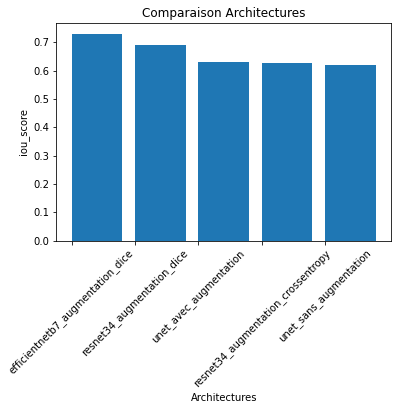

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline
comp_iou= data.iou_score.sort_values( ascending=False)

plt.bar(comp_iou.index, comp_iou.values, align='edge')
plt.xticks(rotation=45)
plt.xlabel('Architectures')
plt.ylabel('iou_score')
plt.title ("Comparaison Architectures")



Text(0.5, 1.0, 'Comparaison Architectures')

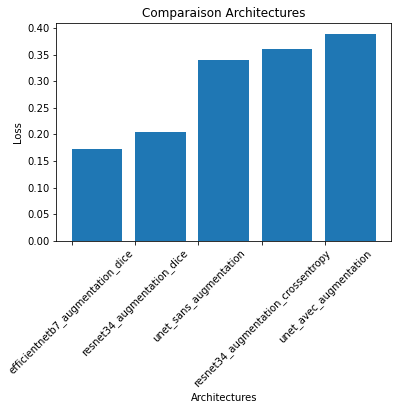

In [37]:
comp_loss= data.loss.sort_values( ascending=True)

plt.bar(comp_loss.index, comp_loss.values, align='edge')
plt.xticks(rotation=45)
plt.xlabel('Architectures')
plt.ylabel('Loss')
plt.title ("Comparaison Architectures")